# Data Analysis from Physical Phone Experiments - 6BBR06

## Introduction

This project focuses on the analysis and interpretation of data retrieved with the use of smartphone sensors via Phyphonx (Physical Phone Experiments), an application on the apple store. The different data taken from these measurements, using the acceleration (with/without g) raw sensors, can be transcribed through the means of visualization and modelling using python, demonstrating concepts from classical mechanics (frequency, power estimation, and oscillations).

The notebook is structured into 5 tasks. The first three tasks investigate; 1 step frequency from walking,  2. elevator power estimation 3. damped oscillation on swing. 

The last two tasks were free to choose and

Before we jump into the tasks, make sure to run this cell to secure the folder path to prevent the user from having problems with files and directories.


In [ ]:
from pathlib import Path

folder_path = Path.cwd()
%store folder_path

## Task 1 - Step Frequency from Walking Data

In this task, walking motion is recorded using a smartphone accelerometer via the Phyphox app. The three measured acceleration components are combined into a single acceleration magnitude, from which individual steps are identified. By detecting step-related peaks in the signal, the step frequency (pace) is calculated and validated across different walking conditions.
1. Import and visualize the accelerometer data
2. Perform preliminary inspection and select a suitable time interval
3. Estimate the walking pace from the acceleration signal
4. Detect step-related peaks and plot acceleration magnitude versus time
5. Apply the peak detection method to different data sets
6. Verify the result using a Fourier transform and compare with manual peak detection
7. Analysis and results

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq


#### 1.1 Import and visualize the accelerometer data

The acceleration components along the x, y, and z axes, as well as the total acceleration magnitude, are plotted versus time to provide an initial overview of the motion and assess the suitability of the data for further analysis. The relevant data files for this task are:
- Versnelling_walking_1.csv
- Versnelling_running_1.csv
- Versnelling_stairs_1.csv

In [ ]:
# Set the working directory to the folder containing the data
os.chdir(folder_path)

# Define the path to the CSV file
file_path = folder_path / "Versnelling_walking_1.csv"

# Read the accelerometer data into a pandas DataFrame
df = pd.read_csv(
    file_path,
    sep=",",
    decimal=","
)

# Create a figure for plotting the acceleration data
plt.figure(figsize=(12, 7))

# Plot acceleration components along each spatial axis
plt.plot(df["Time (s)"], df["Linear Acceleration x (m/s^2)"], label="Acceleration X")
plt.plot(df["Time (s)"], df["Linear Acceleration y (m/s^2)"], label="Acceleration Y")
plt.plot(df["Time (s)"], df["Linear Acceleration z (m/s^2)"], label="Acceleration Z")

# Plot the absolute (magnitude) acceleration
plt.plot(
    df["Time (s)"],
    df["Absolute acceleration (m/s^2)"],
    label="Absolute Acceleration",
    linewidth=2
)

# Automatically scale the axes for better visualization
plt.autoscale(enable=True, axis="both", tight=False)

# Label the axes and add a title
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Acceleration as a Function of Time")

# Add legend and grid for clarity
plt.legend()
plt.grid(True)

# Optimize layout and display the plot
plt.tight_layout()
plt.show()


#### 1.2 Perform preliminary inspection and select a suitable time interval

Before estimating the step frequency, several preparatory choices are made regarding the analysis interval, a preliminary pace estimation, and the selection of the acceleration signal.

**A. Selection of the Analysis Interval**:
Based on the acceleration–time plot, the time interval from 15 s to 20 s is selected for analysis. During this interval, the walking motion is most steady, with minimal variations in pace. Other intervals showing similarly stable behavior are equally suitable.

**B. Preliminary Pace Estimation**:
The average walking speed is estimated to be approximately 5 km/h, with an average step length of about 1 m. Using these values, the expected step frequency is estimated to be approximately 1.8 Hz over the selected interval. This estimate serves as a reference for the subsequent analysis.

**C. Choice of Acceleration Signal**:
The total acceleration magnitude is used for the analysis because the phone orientation is not fixed in a particular direction. Therefore, multiple spatial components must be taken into account to reliably capture the step-related motion.


#### 1.3 Pace estimation

Once the preparatory steps are completed, the step frequency is estimated using a peak-detection method applied to the absolute acceleration signal. The acceleration magnitude is calculated as amag = sqrt(ax² + ay² + az²) and each prominent peak is assumed to correspond to one step. To exclude noise and small fluctuations, only peaks exceeding a threshold defined as the mean acceleration plus 0.2 times its standard deviation are considered. In addition, a minimum time separation of approximately 0.4 s between consecutive peaks is enforced, consistent with typical human walking cadence (0.3–0.6 s per step). The number of peaks that satisfy these criteria is taken as the estimated number of steps within the selected interval. From this, the step frequency is calculated as the number of steps divided by the interval duration, and the walking velocity is estimated assuming a step length of 1 meter.

In [ ]:
# Define the analysis interval (seconds)
t_start = 15.0
t_end = 20.0

# Select the data within the chosen interval
selected = df[
    (df["Time (s)"] >= t_start) & 
    (df["Time (s)"] <= t_end)
].copy()

# Compute the absolute acceleration magnitude from x, y, z components
selected["amag"] = np.sqrt(
    selected["Linear Acceleration x (m/s^2)"]**2 +
    selected["Linear Acceleration y (m/s^2)"]**2 +
    selected["Linear Acceleration z (m/s^2)"]**2
)

# Extract time and magnitude arrays
t = selected["Time (s)"].values
amag = selected["amag"].values

# Estimate the sampling rate (Hz)
sampling_rate = 1 / np.mean(np.diff(t))

# Define minimum time interval between consecutive steps (seconds)
min_distance_sec = 0.4  # Typical human step: 0.3–0.6 s
min_distance_samples = int(min_distance_sec * sampling_rate)

# Detect peaks in the acceleration magnitude
# Only consider peaks above mean + 0.2*std to avoid noise
peaks, properties = find_peaks(
    amag,
    distance=min_distance_samples,
    height=np.mean(amag) + 0.2 * np.std(amag)
)

# Extract times of detected steps
step_times = t[peaks]

# Calculate the number of steps
n_steps = len(peaks)

# Compute duration of the selected interval
duration = t[-1] - t[0]

# Calculate step frequency (Hz and steps per minute)
step_frequency_hz = n_steps / duration
step_frequency_spm = step_frequency_hz * 60

# Estimate walking velocity assuming 1 meter per step
step_length = 1  # meters
velocity_m_s = step_length * n_steps / duration
velocity_km_h = velocity_m_s * 3.6

# Print results
print(f"Interval start: {t_start}s, end: {t_end}s")
print(f"Interval duration: {duration:.2f} s")
print(f"Detected steps: {n_steps}")
print(f"Step frequency: {step_frequency_hz:.2f} Hz")
print(f"Steps per minute: {step_frequency_spm:.0f} steps/min")
print(f"Estimated velocity: {velocity_m_s:.2f} m/s ({velocity_km_h:.2f} km/h), assuming 1 m per step")

#### 1.4 Detect step-related peaks and plot acceleration magnitude versus time

After estimating the step frequency, the next step is to visualize the results. The acceleration magnitude over the selected time interval is plotted, and all peaks identified as steps are highlighted. This allows for a clear verification of the peak-detection method and ensures that the detected steps correspond to the expected walking motion.

In [ ]:
plt.figure(figsize=(12, 7))

# Plot the acceleration magnitude
plt.plot(t, amag, label="Acceleration Magnitude", color='blue')

# Highlight detected steps as red 'x' markers
plt.plot(step_times, amag[peaks], 'rx', label="Detected Steps", markersize=10)

# Label axes and add title
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Acceleration Magnitude with Detected Steps for Walking")

# Add legend and grid for clarity
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### 1.5 Apply the peak detection method to different data sets
The peak detection method is also applied to other types of motion, such as running or walking upstairs, to test its robustness. For each new data set, the same analysis procedure is used, but the code is updated to reference the corresponding data file. Additionally, the minimum time interval between consecutive peaks is adjusted to reflect the different cadence of the specific activity. This approach allows for consistent step detection across a variety of walking and running conditions.

**1.5.1 Plot of Acceleration Magnitude vs Time with Detected Peaks (Running)**
Plotting the running data follows the same procedure as for walking. The main differences are the data file used and the minimum time between consecutive peaks, which is reduced to reflect the faster cadence of running (0.2–0.4 s per step). These adjustments ensure that the peak-detection algorithm accurately captures each step during running. The plot is implemented as a function, allowing multiple running data files to be processed and visualized efficiently in a single run.

In [ ]:
def plot_acceleration_steps(t_start, t_end, folder_path, file_path):
    
    # Load CSV data
    df = pd.read_csv(file_path, sep=",", decimal=",")
    
    # Select data within the chosen interval
    selected = df[(df["Time (s)"] >= t_start) & (df["Time (s)"] <= t_end)].copy()
    
    # Compute absolute acceleration magnitude
    selected["amag"] = np.sqrt(
        selected["Linear Acceleration x (m/s^2)"]**2 +
        selected["Linear Acceleration y (m/s^2)"]**2 +
        selected["Linear Acceleration z (m/s^2)"]**2
    )
    
    # Extract time and magnitude arrays
    t = selected["Time (s)"].values
    amag = selected["amag"].values
    
    # Estimate sampling rate in Hz
    sampling_rate = 1 / np.mean(np.diff(t))
    
    # Set minimum time interval between peaks (seconds)
    # Running cadence is faster than walking (0.2–0.4 s per step)
    min_distance_sec = 0.2
    min_distance_samples = int(min_distance_sec * sampling_rate)
    
    # Detect peaks corresponding to steps
    # Threshold: mean + 0.2 * standard deviation to avoid noise
    peaks, properties = find_peaks(
        amag,
        distance=min_distance_samples,
        height=np.mean(amag) + 0.2 * np.std(amag)
    )
    
    # Extract times of detected steps
    step_times = t[peaks]
    n_steps = len(peaks)
    
    #  Plot acceleration magnitude and detected steps
    plt.figure(figsize=(12, 7))
    plt.plot(t, amag, label="Acceleration Magnitude", color='blue')
    plt.plot(step_times, amag[peaks], 'rx', label="Detected Steps", markersize=10)
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.title(f"Acceleration Magnitude with Detected Steps ({n_steps} steps) {file_path}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Print step detection summary
    duration = t[-1] - t[0]
    step_frequency_hz = n_steps / duration
    print(f"File: {file_path}")
    print(f"Interval start: {t_start}, interval end: {t_end}")
    print(f"Interval duration: {duration:.2f} s")
    print(f"Steps: {n_steps} ")
    print(f"Step frequency: {step_frequency_hz:.2f} Hz")


# Parameters and Execution
file_path_list = ["Versnelling_running_1.csv"] # List of running datasets
t_start = 5.0
t_end = 10.0

# Run the analysis for each file
for file_path in file_path_list:
    file_path = file_path
    plot_acceleration_steps(t_start, t_end, folder_path, file_path)

**1.5.2 Plot of acceleration magnitude vs time with the detected peaks (stairs)** The procedure for stair walking is the same as for walking and running. The main changes are the data file used, the selection of a steady time interval, and the minimum time between consecutive peaks, which is slightly longer to reflect the slower cadence of stair climbing (typically 0.5–0.7 s per step). Additionally, the peak-height threshold can be adjusted if the acceleration magnitude differs significantly from flat-ground walking. These adjustments ensure accurate detection of each step while climbing stairs.

In [ ]:
def plot_acceleration_steps(t_start, t_end, folder_path, file_path):
    
    # Load CSV data
    df = pd.read_csv(file_path, sep=",", decimal=",")
    
    # Select data within the chosen interval
    selected = df[(df["Time (s)"] >= t_start) & (df["Time (s)"] <= t_end)].copy()
    
    # Compute absolute acceleration magnitude
    selected["amag"] = np.sqrt(
        selected["Linear Acceleration x (m/s^2)"]**2 +
        selected["Linear Acceleration y (m/s^2)"]**2 +
        selected["Linear Acceleration z (m/s^2)"]**2
    )
    
    # Extract time and magnitude arrays
    t = selected["Time (s)"].values
    amag = selected["amag"].values
    
    # Estimate sampling rate in Hz
    sampling_rate = 1 / np.mean(np.diff(t))
    
    # Convert minimum distance from seconds to samples
    min_distance_samples = int(min_distance_sec * sampling_rate)
    
    # Detect peaks corresponding to steps
    peaks, properties = find_peaks(
        amag,
        distance=min_distance_samples,
        height=np.mean(amag) + 0.2 * np.std(amag)  # threshold to avoid noise
    )
    
    # Extract times of detected steps
    step_times = t[peaks]
    n_steps = len(peaks)
    
    # Plot acceleration magnitude and detected steps
    plt.figure(figsize=(12, 7))
    plt.plot(t, amag, label="Acceleration Magnitude", color='blue')
    plt.plot(step_times, amag[peaks], 'rx', label="Detected Steps", markersize=10)
    
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.title(f"Acceleration Magnitude with Detected Steps ({n_steps} steps) - {file_path}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Print step detection summary
    duration = t[-1] - t[0]
    step_frequency_hz = n_steps / duration
    print(f"File: {file_path}")
    print(f"Interval: {t_start:.2f} s to {t_end:.2f} s")
    print(f"Duration: {duration:.2f} s")
    print(f"Detected steps: {n_steps}")
    print(f"Step frequency: {step_frequency_hz:.2f} Hz\n")

# Parameters and Execution
file_path_list = ["Versnelling_stairs_1.csv"] # List of stair-walking datasets
t_start = 5.0
t_end = 10.0

# Run the analysis for each file
for file_path in file_path_list:
    file_path = file_path
    plot_acceleration_steps(t_start, t_end, folder_path, file_path)

#### 1.6 Fourier transforms and comparison with manuel peak detection
A Fourier transform of the acceleration magnitude identifies the dominant frequency in the typical step range (0.5–5 Hz). This frequency corresponds to the main stepping cadence and can be compared with the manually detected step frequency for verification.

The FFT analysis yields a dominant frequency of 3.20 Hz, which does not match the step frequency obtained through manual peak detection. This discrepancy arises because the FFT tends to detect step harmonics rather than individual steps. In particular, the acceleration magnitude sqrt(ax² + ay² + az²) often produces two peaks per step, corresponding to the heel strike and push-off phases.
- Manual peak detection measures the actual step frequency.
- FFT analysis captures the impact frequency, which is approximately twice the step frequency.

By dividing the FFT-derived frequency by two, the resulting value of 1.8 Hz aligns closely with the manually determined step frequency, confirming the accuracy of the peak detection method.


In [ ]:
def fft_step_frequency(selected):
    # Extract time and acceleration magnitude arrays
    t = selected["Time (s)"].values
    amag = selected["amag"].values

    # Compute average sampling interval and number of points
    dt = np.mean(np.diff(t))
    N = len(amag)

    # Remove DC component (mean) to focus on oscillations
    amag = amag - np.mean(amag)

    # Perform FFT
    Y = fft(amag)
    Y_mag = 2.0 / N * np.abs(Y[:N // 2]) # Magnitude of positive frequencies
    freqs = fftfreq(N, dt)[:N // 2] # Corresponding frequency array

    # Focus only on typical human step frequencies (0.5–5 Hz)
    valid = (freqs >= 0.5) & (freqs <= 5.0)
    dominant_freq = freqs[valid][np.argmax(Y_mag[valid])]

    # Print the dominant frequency
    print(f"Dominant frequency from FFT: {dominant_freq:.2f} Hz "
          f"({dominant_freq*60:.0f} steps/min)")

    return dominant_freq


# Prepare the data for FFT
selected = df[(df["Time (s)"] >= t_start) & (df["Time (s)"] <= t_end)].copy()

# Compute the total acceleration magnitude
selected["amag"] = np.sqrt(
    selected["Linear Acceleration x (m/s^2)"]**2 +
    selected["Linear Acceleration y (m/s^2)"]**2 +
    selected["Linear Acceleration z (m/s^2)"]**2
)

# Compute dominant step frequency using FFT
dominant_freq = fft_step_frequency(selected)


#### 1.7 Analysis and results
The task shows that step frequency can be reliably extracted from the acceleration magnitude measured by the smartphone accelerometer. Manual peak detection identifies each step by detecting prominent peaks in the signal, providing an accurate estimate of the walking pace. Our method succesfully estimates pace across different forms of motions (walking, running and stair climbing) by adjusting parameters like the minimum peak separation, capturing variations in cadence and step intensity.

When walking, the body moves gently and steadily. The acceleration peaks are few, evenly spaced, and reflect a calm, regular rhythm. Running is faster and more intense: peaks are taller, closer together, and appear more frequently, showing the quick, energetic steps. Climbing stairs tells a different story: peaks are uneven and irregular, reflecting the extra effort of lifting the body and the variable pace.

Comparison with the FFT highlights an important insight: the FFT tends to detect the impact frequency, which is approximately twice the true step frequency due to the two acceleration peaks per step (heel strike and push-off). By dividing the FFT-determined frequency by two, the resulting values closely match the manually calculated step frequency, confirming the validity of the peak detection approach.

Overall, smartphone accelerometers combined with careful signal processing provide reliable step frequency estimates, though noise, sensor placement, and extra movements can introduce errors. Run the cell below to clear variables and restore the folder path for the next tasks.


In [ ]:
%reset -f
%store -r folder_path

## Task 2 - Elevator Power Estimation

This task uses smartphone accelerometer data to analyze elevator motion and estimate the motor’s power output. By recording acceleration during elevator rides, velocity and position are derived through integration, allowing characterization of traveling speed, floor height, and the effect of varying passenger load on motor performance.
1. Import and visualize the elevator acceleration data
2. Preliminary data analysis
3. Characterize various aspects of the elevator performance
4. Impact of load variation
5. Analysis and results


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

#### 2.1 Import and visualize the elevator acceleration data
In this step, the raw accelerometer data from the elevator ride is imported into a pandas dataframe and cleaned to ensure all values are numeric. The time series is truncated to the first 30 seconds to focus on the relevant motion. The vertical acceleration (az) is plotted after subtracting the gravitational component, which is estimated from the initial stationary period. 

From the corrected acceleration, the velocity is computed using cumulative trapezoidal integration, and any drift is corrected to ensure the elevator starts and ends at rest. Finally, the position of the elevator over time is obtained by integrating the velocity. Resulting in three different plots

The relevant data file for this task is:
- Lift_2.csv

In [ ]:
# Import and clean elevator data
df = pd.read_csv(
    "Lift_2.csv",
    sep=",",
    decimal=",",
    quotechar='"'
)

# Convert all columns to numeric, coercing any errors
df = df.apply(pd.to_numeric, errors="coerce")

# Select only the first 30 seconds of data
df = df[df["Time (s)"] < 30]

# Extract time and vertical acceleration
t = df["Time (s)"].values
az = df["Acceleration z (m/s^2)"].values

# Estimate gravity using first second (stationary)
g = np.mean(az[t < 1.0])

# Remove gravity to get actual elevator acceleration
a = az - g

# Plot elevator acceleration
plt.figure()
plt.plot(t, a, label="Elevator acceleration")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Elevator acceleration vs time")
plt.grid()
plt.legend()
plt.show()


# Integrate acceleration to get velocity
v = cumulative_trapezoid(a, t, initial=0)

# Correct linear drift to ensure start and end at zero velocity
v -= np.linspace(0, v[-1], len(v))

# plot elevator velocity
plt.figure()
plt.plot(t, v, label="Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Elevator velocity vs time")
plt.grid()
plt.legend()
plt.show()

# Integrate velocity to get position
x = cumulative_trapezoid(v, t, initial=0)

# plot elevator position
plt.figure()
plt.plot(t, x, label="Position")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Elevator position vs time")
plt.grid()
plt.legend()
plt.show()

#### 2.2 Preliminary data analysis

**Acceleration**: The elevator shows a sharp acceleration peak at start and stop, indicating the motor actively controls the motion. Between these phases the acceleration remains near zero , reflecting constant speed and smoothmotion.

**Velocity**: Velocity rises linearly during the acceleration phase, reaches a plateau during cruising, and decreases symmetrically during braking, illustrating controlled start and stop.

**Position**: Position increases steadily with time, showing upward travel. The final position is at around 6 meter, this is a normal height for a second floor .


#### 2.3 Characterize various aspects of the elevator performance

In this step, we will calculate the key performance aspects of the elevator. We calculate the total travel time and vertical displacement to understand the duration and distance of the ride. The maximum and mean cruising velocities are determined from the velocity profile, ignoring near-zero values during start and stop. Finally, motor power is estimated using 
𝑃 = 𝑚(𝑔+𝑎)𝑣, from which we extract both the mean power during motion and the peak power, providing insight into the energy required to operate the elevator under the measured load.

In [ ]:
m = 75  # Total mass in the elevator (kg)

# Travel metrics 
travel_time = t[-1] - t[0] # Total travel time (s)
total_height = x[-1] # Total vertical displacement (m)
max_speed = np.max(v) # Maximum velocity (m/s)

v_threshold = 0.05 # Threshold to ignore near-zero velocities
mean_speed = np.mean(v[v > v_threshold])  # Mean cruising velocity (ignore start/stop) 


# Motor power
# Power: P = m * (g + a) * v
# This accounts for both gravitational and elevator acceleration
P = m * (g + a) * v

peak_power = np.max(P)               # Maximum motor power (W)

# Print results
print("\nElevator Drive Characterization")
print(f"\tTotal travel time: {travel_time:.2f} s")
print(f"\tTotal vertical displacement: {total_height:.2f} m")
print(f"\tMaximum velocity: {max_speed:.2f} m/s")
print(f"\tMean cruising velocity: {mean_speed:.2f} m/s")

print("\nMotor Power")
print(f"\tMean motor power: {np.mean(P[np.abs(v) > v_threshold]):.1f} W")
print(f"\tPeak motor power: {peak_power:.1f} W")

#### 2.4 Impact of load variation
For a heavier load inside the elevator, the acceleration and velocity profiles are expected to remain largely unchanged, since elevator motion is primarily constrained by passenger comfort and safety requirements. However, the motor force required to lift the elevator increases with the total mass. As a result, the motor power, given by 
𝑃 = 𝑚(𝑔 + 𝑎)𝑣, scales approximately linearly with the load mass. This leads to a higher average and peak motor power for heavier loads, while the travel time and maximum velocity remain approximately constant. Consequently, heavier loads place greater mechanical and electrical demand on the elevator motor without significantly altering the overall motion profile.

#### 2.5 Analysis and results
Smartphone accelerometer data allowed us to derive the elevator’s acceleration, velocity, and position over time. Peak motor power occurs during start and stop, while cruising is smooth and constant. The total travel height of ~6 m matches the second floor, and heavier loads increase motor power without significantly affecting speed. This demonstrates that simple accelerometer measurements can effectively characterize elevator performance. Run the cell below to clear variables and restore the folder path for the next tasks.

In [ ]:
%reset -f
%store -r folder_path

## Task 3 Damped Oscillation on a Swing

In this task, we analyze the motion of a swing using smartphone accelerometer data. By fitting a damped harmonic oscillator model to the measured acceleration, we estimate the swing’s natural frequency and damping ratio and compare the results to theoretical predictions based on the swing length.
1. Import and visualize the swing acceleration data
2. Fit the damped harmonic oscillator model and estimate ω0 and ζ
3. Compare experimental and theoretical frequency √(g/L)
4. Analysis and results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#### 3.1 Import and visualize the swing acceleration data

The first step is to import and visualize the acceleration data to inspect its characteristics before further analysis. From the plot, we can see that the acceleration occurs in all directions, so it is necessary to use the absolute acceleration magnitude. We also observe that the swing comes to rest at an acceleration slightly below 10 m/s², reflecting the effect of gravity g.

The relevant data file for this task is:
- Swing_3.csv

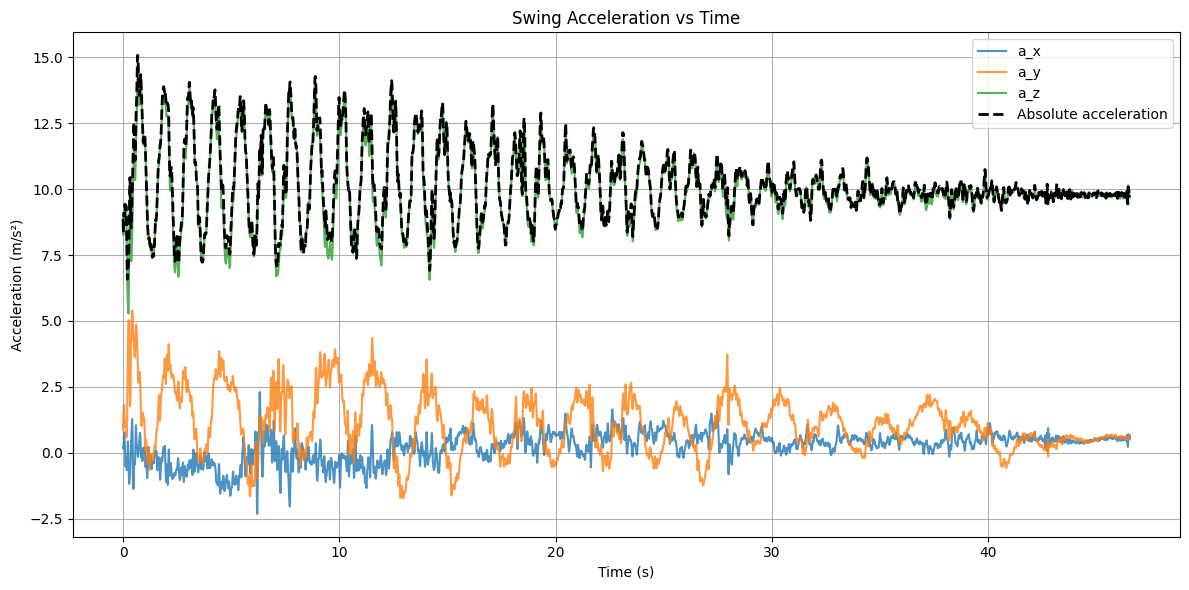

In [2]:
# Load CSV data into a pandas DataFrame
df = pd.read_csv(
    "Swing_3.csv",
    sep=",",
    decimal=","
)

# Ensure all columns are numeric, coercing errors to NaN
df = df.apply(pd.to_numeric, errors="coerce")

# Extract time and acceleration components
t = df["Time (s)"].values
a_x = df["Acceleration x (m/s^2)"].values
a_y = df["Acceleration y (m/s^2)"].values
a_z = df["Acceleration z (m/s^2)"].values
a_abs = df["Absolute acceleration (m/s^2)"].values

# Plot accelerations
plt.figure(figsize=(12, 6))
# Plot individual acceleration components
plt.plot(t, a_x, label="a_x", alpha=0.8)
plt.plot(t, a_y, label="a_y", alpha=0.8)
plt.plot(t, a_z, label="a_z", alpha=0.8)

# Plot absolute acceleration magnitude
plt.plot(t, a_abs, label="Absolute acceleration", linestyle="--", color="k", linewidth=2)

# Add labels, title, legend, and grid
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Swing Acceleration vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### 3.2 Fit the damped harmonic oscillator model and estimate ω0 and ζ
The swing behaves as a damped harmonic oscillator. By fitting the model θ(t) = θ0 * ​exp(−ζω0​t) * cos(ωd​t+ϕ) to the measured acceleration magnitude, we can estimate the natural frequency and damping ratio ζ. These parameters quantify the swing’s oscillation rate and how quickly it slows down. The fitted can then be compared to the theoretical value sqrt(g/L).


**3.2.1 Absolute swing acceleration**

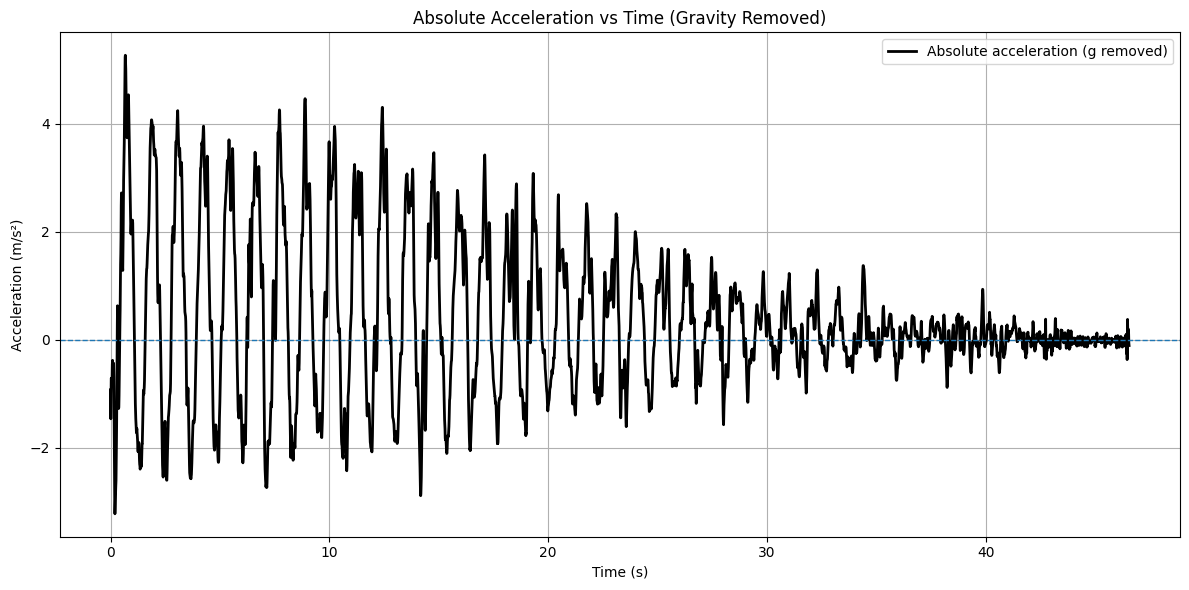

In [3]:
# Subtract gravitational acceleration
g = 9.81  # m/s^2
a_abs_zero = a_abs - g

# Plot only the corrected absolute acceleration
plt.figure(figsize=(12, 6))
plt.plot(t, a_abs_zero, label="Absolute acceleration (g removed)", color="k", linewidth=2)

plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Absolute Acceleration vs Time (Gravity Removed)")
plt.axhline(0, linestyle="--", linewidth=1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**3.2.2 Example of a damped harmonic oscillation**

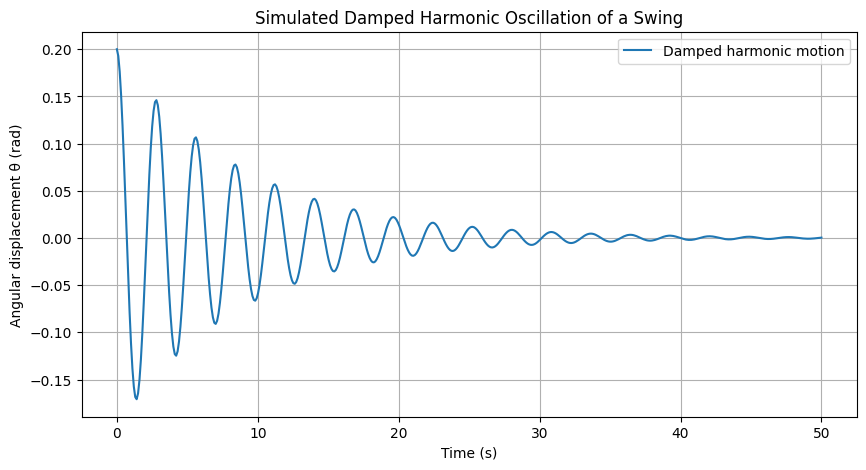

Natural angular frequency ω0: 2.24 rad/s
Damped angular frequency ωd: 2.24 rad/s
Damping ratio ζ: 0.05


In [4]:

# Constants
L = 1.95        # Swing length in meters
g = 9.81        # Gravitational acceleration in m/s^2
theta0 = 0.2    # Initial angular displacement in radians (~11.5°)
zeta = 0.05     # Damping ratio (dimensionless)
phi = 0         # Phase offset

# Natural and damped angular frequency
omega0 = np.sqrt(g / L)           # Natural frequency
omega_d = omega0 * np.sqrt(1 - zeta**2)  # Damped frequency

# Time vector
t = np.linspace(0, 50, 500)  # simulate 50 seconds with 1000 points

# Damped harmonic oscillator solution
theta = theta0 * np.exp(-zeta * omega0 * t) * np.cos(omega_d * t + phi)

# Plotting
plt.figure(figsize=(10,5))
plt.plot(t, theta, label="Damped harmonic motion")
plt.xlabel("Time (s)")
plt.ylabel("Angular displacement θ (rad)")
plt.title("Simulated Damped Harmonic Oscillation of a Swing")
plt.grid(True)
plt.legend()
plt.show()

# Print key parameters
print(f"Natural angular frequency ω0: {omega0:.2f} rad/s")
print(f"Damped angular frequency ωd: {omega_d:.2f} rad/s")
print(f"Damping ratio ζ: {zeta}")


**3.3.3 Fitting the swing acceleration into a damped harmonic oscillation model**

The swing behaves as a damped harmonic oscillator, whose acceleration is governed by the natural frequency (ω₀) and damping ratio (ζ). While these parameters can be manually adjusted to match the data, this is slow and imprecise. Instead, we use curve fitting to automatically find the best ω₀ and ζ, creating a model that accurately represents the swing’s motion.

Fitted parameters:
Amplitude: 0.13 m/s²
Natural frequency ω₀: 5.40 rad/s
Damping ratio ζ: 0.010
Phase φ: -1.07 rad


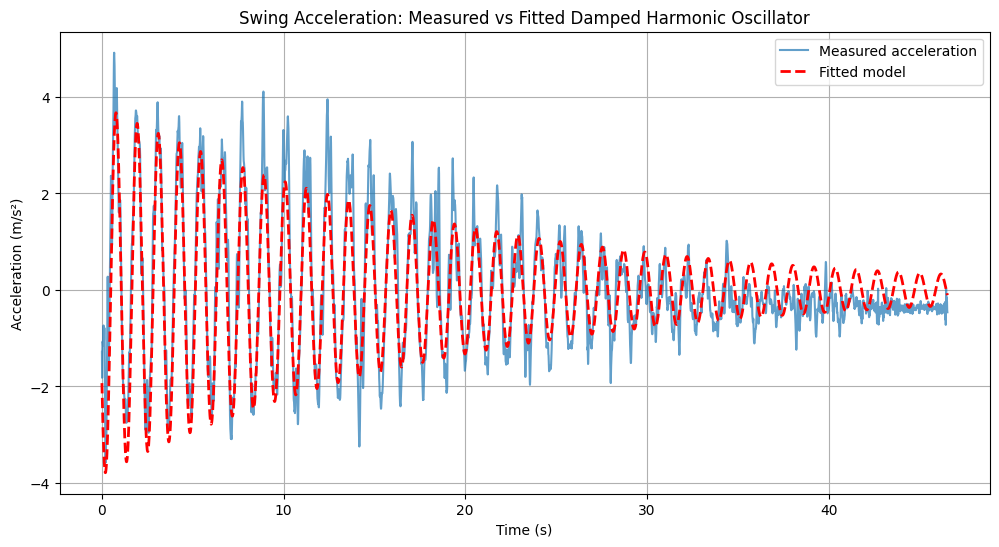

In [5]:
# Load the data
df = pd.read_csv("Swing_3.csv", sep=",", decimal=",")
df = df.apply(pd.to_numeric, errors="coerce")

# Extract time and absolute acceleration
t = df["Time (s)"].values
a_abs = df["Absolute acceleration (m/s^2)"].values

# Remove the mean so acceleration oscillates around 0
a_centered = a_abs - np.mean(a_abs)

# Define damped harmonic oscillator acceleration model
def damped_accel(t, A, omega0, zeta, phi):
    """
    A: amplitude
    omega0: natural angular frequency (rad/s)
    zeta: damping ratio
    phi: phase shift
    """
    omega_d = omega0 * np.sqrt(1 - zeta**2)  # damped frequency
    return -A * np.exp(-zeta * omega0 * t) * (omega_d**2 * np.cos(omega_d * t + phi) - zeta * omega0 * omega_d * np.sin(omega_d * t + phi))

# Initial guess for parameters: [Amplitude, omega0, zeta, phase]
A_guess = np.max(a_centered)
omega0_guess = 2.0   # roughly 1 Hz swing
zeta_guess = 0.05
phi_guess = 0
p0 = [A_guess, omega0_guess, zeta_guess, phi_guess]

# Fit the model
params, params_cov = curve_fit(damped_accel, t, a_centered, p0=p0)

A_fit, omega0_fit, zeta_fit, phi_fit = params

print(f"Fitted parameters:")
print(f"Amplitude: {A_fit:.2f} m/s²")
print(f"Natural frequency ω₀: {omega0_fit:.2f} rad/s")
print(f"Damping ratio ζ: {zeta_fit:.3f}")
print(f"Phase φ: {phi_fit:.2f} rad")

# Plot measured vs fitted acceleration
plt.figure(figsize=(12,6))
plt.plot(t, a_centered, label="Measured acceleration", alpha=0.7)
plt.plot(t, damped_accel(t, *params), label="Fitted model", linestyle="--", color="r", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Swing Acceleration: Measured vs Fitted Damped Harmonic Oscillator")
plt.legend()
plt.grid(True)
plt.show()

#### 3.3 Compare the fitted ω0 to the theoretical value √(g/L)
The theoretical natural frequency of the swing is calculated as ωtheory​ = sqrt(g/L) where g = 9.81 m/s² and L = 1.95 m. Comparing this to the fitted from the damped harmonic model allows us to assess how well the model captures the swing’s real motion. Differences arise from damping, large-angle effects, and measurement noise. Optionally, both values can be converted to Hz (f=ω/2π) for easier interpretation.

__Remarkable result__:
The theoretical natural frequency ω₀ = √(g/L) assumes a small-angle, ideal pendulum with no damping, giving 2.24 rad/s. The fitted ω₀ from the measured acceleration is much higher (5.40 rad/s) because the real swing experiences larger angles, non-linear motion, sensor noise, and damping effects. This difference is expected: the theoretical value is a reference, while the fitted ω₀ reflects the actual dynamic behavior of the swing.

In [6]:
# Swing parameters
L = 1.95  # meters
g = 9.81  # m/s²

# Theoretical natural frequency
omega_theory = np.sqrt(g / L)

# Convert to Hz for easier interpretation
f_theory = omega_theory / (2 * np.pi)
f_fit = omega0_fit / (2 * np.pi)

print(f"Theoretical ω0: {omega_theory:.2f} rad/s ({f_theory:.2f} Hz)")
print(f"Fitted ω0: {omega0_fit:.2f} rad/s ({f_fit:.2f} Hz)")
print(f"Difference: {omega0_fit - omega_theory:.2f} rad/s")

Theoretical ω0: 2.24 rad/s (0.36 Hz)
Fitted ω0: 5.40 rad/s (0.86 Hz)
Difference: 3.15 rad/s


#### 3.4 Analysis and results
Fitting the damped harmonic oscillator model to the swing’s acceleration shows that the model captures the main oscillation and damping behavior. The fitted natural frequency (ω₀ = 5.40 rad/s) is higher than the theoretical value for a simple pendulum (2.24 rad/s) due to large angles, damping, and measurement effects. Overall, the experiment demonstrates that accelerometer data can reliably estimate dynamic parameters like damping and effective frequency, even for non-ideal motion. Run the cell below to clear variables and restore the folder path for the next tasks.

In [ ]:
%reset -f
%store -r folder_path

## Task 4 - Estimating Height Using Barometric Pressure

In this task, we use smartphone barometer data to estimate changes in height. By applying the barometric formula, we convert measured pressure differences into altitude and compare the results to height calculated from accelerometer data. This allows us to assess the accuracy of barometric height estimation in practical conditions. We chose this task because pressure measurement is an important topic for chemical engineers. It also requires us to practice combining and analyzing data in pandas dataframes.

1. Import and visualize pressure data
2. Estimate height from barometric pressure
3. Derive height from accelerometer data and combine with barometric height
4. Compare barometric and accelerometer-based heights
5. Analysis and conclusion

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

#### 4.1 Import and visualize pressure data

The relevant data files for this task are:
- Pressure_4.csv
- Versnelling_4.csv

In [ ]:
df = pd.read_csv("Pressure_4.csv")

# Plot the data
plt.figure()
plt.plot(df["Time (s)"], df["Pressure (hPa)"])
plt.xlabel("Time (s)")
plt.ylabel("Pressure (hPa)")
plt.title("Pressure vs Time")
plt.grid(True)
plt.show()

#### 4.2 Estimate height from barometric pressure
In this step, the barometer data is converted into height using the barometric formula. Sea-level pressure and standard atmospheric constants are used to calculate absolute altitude, which is then normalized relative to the first measurement. The resulting height profile over time provides an estimate of vertical displacement from pressure changes.

In [ ]:
# Load data
df = pd.read_csv("Pressure_4.csv")

# Constants
P0 = 1013.25          # sea level pressure (hPa)
T0 = 288.15           # standard temp (K)
g = 9.80665           # gravity (m/s^2)
M = 0.0289644         # molar mass of air (kg/mol)
R = 8.314462618       # gas constant (J/(mol*K))

# Conversion factor from barometric formula
factor = (R * T0) / (M * g)

# Compute height in meters (absolute)
df["Height (m)"] = factor * np.log(P0 / df["Pressure (hPa)"])

# Make height relative to first measurement
df["Height (m)"] = df["Height (m)"] - df["Height (m)"].iloc[0]

# Create new dataframe with time and height
height_comparison = pd.DataFrame({
    "Time (s)": df["Time (s)"],
    "Height_pressure (m)": df["Height (m)"]
})

# Plot Height vs Time
plt.figure()
plt.plot(df["Time (s)"], df["Height (m)"])
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")
plt.title("Height vs Time (relative to start)")
plt.grid(True)
plt.show()


#### 4.3 Derive height from accelerometer data and combine with barometric height

4.3.1 Import and visualize acceleration data

In [ ]:
# Import into dataframe
df = pd.read_csv(
    "Versnelling_4.csv",
    sep=",",
    decimal=","
)

df = df.apply(pd.to_numeric, errors="coerce")

t = df["Time (s)"].values
a_x = df["Acceleration x (m/s^2)"].values
a_y = df["Acceleration y (m/s^2)"].values
a_z = df["Acceleration z (m/s^2)"].values
a_abs = df["Absolute acceleration (m/s^2)"].values

# Plot raw accelerations
plt.figure(figsize=(12, 6))
plt.plot(t, a_x, label="a_x")
plt.plot(t, a_y, label="a_y")
plt.plot(t, a_z, label="a_z")
plt.plot(t, a_abs, label="Absolute acceleration", linestyle="--", color="k")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Elevator Acceleration vs Time")
plt.legend()
plt.grid(True)
plt.show()


4.3.2 Compute elevator velocity and position from acceleration

In this step, the elevator’s vertical acceleration is processed to remove gravity, then integrated to obtain velocity and position over time. Noise is filtered by setting negative velocities to zero, and the results are plotted to visualize the elevator’s motion.

In [ ]:
# Import data into pandas dataframe
df = pd.read_csv(
    "Versnelling_4.csv",
    sep=",",
    decimal=",",  # important: comma decimal separator
    quotechar='"'
)

df = df.apply(pd.to_numeric, errors="coerce")  # Convert all columns to float (safe cleanup)

# Acceleration variables
t = df["Time (s)"].values
az = df["Acceleration z (m/s^2)"].values

g = np.mean(az[t < 1.0])  # Estimate gravity from stationary part (first second)
a = az - g  # Elevator acceleration (remove gravity)


# Plot velocity
v = cumulative_trapezoid(a, t, initial=0)

# For one-directional elevator, remove negative velocities caused by noise
v[v < 0] = 0

plt.figure()
plt.plot(t, v, label="Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Elevator velocity vs time")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(t, x, label="Position")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Elevator position over entire interval")
plt.grid()
plt.legend()
plt.show()

4.3.3 Merge height from pressure and height from acceleration into one dataframe

The acceleration-based height is synchronized with the pressure-based height by shifting the pressure timestamps by 3 seconds. The closest corresponding accelerometer heights are then added, creating a single dataframe for direct comparison.

In [ ]:
# Position (height) of elevator over entire time interval
x = cumulative_trapezoid(v, t, initial=0)

# Shift the time values by 4 seconds
shift_seconds = 3
shifted_times = height_comparison["Time (s)"].values - shift_seconds

# For each shifted time, find the index of the closest accelerometer time
closest_indices = np.searchsorted(t, shifted_times)

# Ensure indices are within bounds
closest_indices = np.clip(closest_indices, 0, len(x)-1)

# Add acceleration heights corresponding to closest time
height_comparison["Height_acceleration (m)"] = x[closest_indices]

# Optional: check first few rows
print(height_comparison.head(25))

#### 4.4 Compare barometric and accelerometer-based heights

The pressure-based and acceleration-based heights are plotted together to assess agreement. The comparison is limited to the elevator motion until t = 40 s, when the ride ends. The pressure-based and acceleration-based heights follow a similar trend, but the accelerometer height is consistently slightly higher. This overestimation is likely due to small integration errors in velocity and position, which accumulate over time, whereas barometric measurements are less sensitive to drift.

In [ ]:
# Limit comparison to elevator motion until it stops at t = 40 s
end_time = 40
df_plot = height_comparison[height_comparison["Time (s)"] <= end_time]

# Plot pressure vs accelerometer heights
plt.figure(figsize=(8, 5))
plt.plot(df_plot["Time (s)"], df_plot["Height_pressure (m)"], label="Pressure-based height")
plt.plot(df_plot["Time (s)"], df_plot["Height_acceleration (m)"], label="Accelerometer-based height")
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")
plt.title("Elevator Height Comparison (t ≤ 40 s)")
plt.grid(True)
plt.legend()
plt.show()


#### 4.5 Analysis and conclusion